In [1]:
import numpy as np
import pandas as pd
import datetime
import random
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from pylab import rcParams
from pandas import DatetimeIndex
import math
import zipfile
pd.set_option('display.max_columns', None)
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
from datetime import datetime
from dateutil import parser
def parseDate(d):
    try:
        return parser.parse(d)        
    except:
        return None

def maxD(v):
    dt1 = parseDate(v[0])
    dt2 = parseDate(v[1])
    if dt1 is not None and dt2 is not None:
        return max(dt1, dt2)
    elif dt1 is not None:
        return dt1
    else:
        return dt2
    
import datetime
import random

def addDelta(v):
    delta = datetime.timedelta(0,random.randint(1, 15), random.randint(1, 1001))
    dt = parseDate(str(v[0]))
    if dt is not None:
        return dt+delta
    else:
        return dt
    
def num(s):
    try:
        return int(s[0])
    except ValueError:
        return float(s[0])
    except ValueError:
        return None

def differ(v):
    d1 = num(v[0])
    d2 = num(v[1])
    if d1 is not None and d2 is not None and abs(d1-d2)<=10:
        return False
    else:
        return True
    
def pererr(err, avg):
    return (err/avg)*100

def mean(l):
    return reduce(lambda x, y: x + y, l) / len(l)


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

    
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat    
 

/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
zf = zipfile.ZipFile('datasets/order-reports_01_09_2017_14_20.csv.zip') 
kp = pd.read_csv(zf.open('order-reports_01_09_2017_14_20.csv'), header=0)

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,24,27,31,32,33,35,36,66,67,68,69,76,86,88,89,90,91,92,94,96,97,98,101,104,105,106,108,110,111,112,113,114,117,119,121,123,124,126,127,129,130,131,132,133,134,135,136,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
kpi=kp.iloc[:, 
          [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 17, 20, 22, 
           37, 38, 39, 41, 75, 87, 93, 95, 102]]
kpi.count()

Id                      359353
Customer Name           359353
Status                  359353
Shipment Date           359353
From City               359353
To City                 359353
Distance                353871
From Sublocation        359353
To Sublocation          359353
Order Value             283832
Used truck Type         283610
Creation Time           359353
Warehouse Start Loc     359353
Warehouse End Loc       359353
Sector Name             359353
Tonnage                 215205
Per Ton Rate              7864
Freight Amount          281265
Product Name            359353
Order Processing        359353
Order Accepted          104256
Order Blocked           193373
Truck Arrival Source    285188
dtype: int64

In [25]:
kpi['Status'].unique()

array(['Order Accepted', 'Order Processing', 'Truck Checklist Verified',
       'Order Blocked', 'Rate Pending', 'Waiting For Loading',
       'LR Generated', 'Cancelled By Customer', 'Truck Delayed',
       'Truck Arrival Source', 'Advance DocVerification', 'Cancelled',
       'Truck In-Transit', 'Truck Arrival Destination', 'KAM Review',
       'Advance Docs Rejected', 'Advance Payment Rejected',
       'Truck Owner Verification Rejected', 'Order Incomplete',
       'Truck Departure Destination', 'Payment Pending', 'Order Paused',
       'Settlement DocVerification', 'Truck Owner Verification',
       'Ops Review', 'Transit Issue', 'Settlement Done',
       'Settlement Images Uploaded', 'Settlement Pending',
       'Settlement Payment Rejected', 'Settlement Docs Rejected',
       'Truck Rejected', 'Settlement Initiated', 'To Be Settled',
       'Settlement Issue Raised', 'Docs Pending', 'Docs Received',
       'Payment Done', 'Order Completed'], dtype=object)

In [68]:
kpi['date']=kpi[['Order Accepted', 'Order Blocked']].apply(maxD, axis=1)
#kpi.drop(['Order Accepted', 'Order Blocked'], axis=1, inplace=True)
kpi.count()

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Id                      359353
Customer Name           359353
Status                  359353
Shipment Date           359353
From City               359353
To City                 359353
Distance                353871
From Sublocation        359353
To Sublocation          359353
Order Value             283832
Used truck Type         283610
Creation Time           359353
Warehouse Start Loc     359353
Warehouse End Loc       359353
Sector Name             359353
Tonnage                 215205
Per Ton Rate              7864
Freight Amount          281265
Product Name            359353
Order Processing        359353
Order Accepted          104256
Order Blocked           193373
Truck Arrival Source    285188
date                    291377
dtype: int64

In [223]:
kpi[(pd.isnull(kpi['Freight Amount'])==False) & (pd.isnull(kpi['Order Value'])==False)].count()

Id                      278027
Customer Name           278027
Status                  278027
Shipment Date           278027
From City               278027
To City                 278027
Distance                274802
From Sublocation        278027
To Sublocation          278027
Order Value             278027
Used truck Type         278010
Creation Time           278027
Warehouse Start Loc     278027
Warehouse End Loc       278027
Sector Name             278027
Tonnage                 209741
Per Ton Rate              7864
Freight Amount          278027
Product Name            278027
Order Processing        278027
Order Accepted           96112
Order Blocked           187871
Truck Arrival Source    277608
date                    278027
ptr                     207804
date1                        0
d                       278027
dtype: int64

In [42]:
kpi['Product Name'].describe()
kpi['Product Name'].unique()

array(['Powder (Loose)', 'Wire Rod', 'Ingot', 'FMC Durables', 'Chemicals',
       'Paint', 'Oil', 'Packaged Foods', 'Coal', 'Powder (Bags)',
       'Agriculture', 'Sugar', 'Chana', 'Consumer Durables', 'Beverages',
       'Steel', 'Petroleum Coke', 'Wood', 'Polyester', 'Textiles',
       'Metals', 'Snacks', 'Rice', 'Personal Care Products', 'Others',
       'Yellow Peas', 'Wheat', 'PANELS', 'Nutrition', 'Construction',
       'Batteries', 'Rolled Semi', 'Powder', 'Cocoa Beans', 'Paper',
       'Non-metals', 'Crumb', 'Extrusions Semi', 'BLOCKS',
       'Scrap Material', 'Billet', 'Container', 'Bitumen', 'Slab',
       'Solar Panels', 'Powder (Bags) - Big Factory', 'Tiles',
       'Powder Loose (Non - Sample)', 'Powder Loose (Sample)',
       'IT and Electronic Goods', 'Plastic Agglo LD', 'Plastics',
       'Powder (Bags) - Medium Factory', 'Powder (Bags) - Small Factory',
       'Clay', 'Soya', 'VAS', 'Machinery', 'Granite', 'Ceramic', 'Sugar.',
       'Animal Feed', 'Synthetics', 'Scra

In [221]:
kpi['Truck Arrival Source'].count()

281489

In [115]:
kpi = kpi[pd.isnull(kpi['date'])==False]
kpi['ptr'] = (kpi['Freight Amount']/(kpi['Tonnage']*(kpi['Distance']/1000)))
kpi['date'].unique().size

207075

In [30]:
kpi.groupby(['Used truck Type']).count()

,Id,Customer Name,Status,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Shipment Date,Creation Time,Order Processing,Truck Arrival Source,date,ptr
Used truck Type,,,,,,,,,,,,,,,,,,,,,,
16T/15T,126493,126493,126493,126493,126493,125107,126493,126493,126112,126493,126493,126493,93584,641,126493,125550,126493,126493,126493,125803,126493,92739
19ft/7.5T,11949,11949,11949,11949,11949,11829,11949,11949,11932,11949,11949,11949,8529,2,11949,11885,11949,11949,11949,11842,11949,8443
20ft SAC/24ft SAC,7861,7861,7861,7861,7861,7537,7861,7861,7761,7861,7861,7861,3651,0,7861,7760,7861,7861,7861,7813,7861,3442
21T/20T,57296,57296,57296,57296,57296,56995,57296,57296,57158,57296,57296,57296,49580,1727,57296,56981,57296,57296,57296,57070,57296,49320
24ft MAC,61,61,61,61,61,61,61,61,60,61,61,61,39,0,61,60,61,61,61,60,61,39
25T/24T,7475,7475,7475,7475,7475,7421,7475,7475,7435,7475,7475,7475,6977,555,7475,7431,7475,7475,7475,7451,7475,6924
27T/28T,12342,12342,12342,12342,12342,12274,12342,12342,12336,12342,12342,12342,11678,2275,12342,12326,12342,12342,12342,12290,12342,11611
30 MT,1247,1247,1247,1247,1247,1247,1247,1247,1247,1247,1247,1247,1247,1202,1247,1247,1247,1247,1247,1241,1247,1247
32ft HQ,8,8,8,8,8,8,8,8,8,8,8,8,5,0,8,8,8,8,8,8,8,5


In [116]:
kpi['d'] = kpi[['date']].apply(addDelta, axis=1)

In [117]:
kpi['d'].unique().size

291364

In [118]:
kpi.groupby(['From City', 'To City', 'From Sublocation', 'To Sublocation', 'Used truck Type']).count().nlargest(10, 'Id')

Id  \
From City   To City    From Sublocation  To Sublocation Used truck Type         
Pondicherry Chennai    Puducherry        Ponneri        16T/15T          3354   
                                                        19ft/7.5T        2143   
Karnal      Anjar      Dyal Singh Colony Kandla         27T/28T          1922   
Bangalore   Chennai    Bidadi            Periyamet      16T/15T          1590   
            Wada       Bidadi            Kudus          21T/20T          1426   
Pondicherry Hyderabad  Puducherry        Medchal        16T/15T          1418   
Bangalore   Chennai    Bidadi            Periyamet      21T/20T          1350   
Rohtak      New Delhi  Subhash Nagar     Raisina Hills  19ft/7.5T        1074   
Silvassa    Aurangabad Park City         Mondha         16T/15T          1074   
Karnal      Anjar      Dyal Singh Colony Kandla         34T               976   

                                                                         Customer Name  \
From City   To City    From Sublocation  To Sublocation Used truck Type                  
Pondicherry Chennai    Puducherry        Ponneri        16T/15T                   3354   
                                                        19ft/7.5T                 2143   
Karnal      Anjar      Dyal Singh Colony Kandla         27T/28T                   1922   
Bangalore   Chennai    Bidadi            Periyamet      16T/15T                   1590   
            Wada       Bidadi            Kudus          21T/20T                   1426   
Pondicherry Hyderabad  Puducherry        Medchal        16T/15T                   1418   
Bangalore   Chennai    Bidadi            Periyamet      21T/20T                   1350   
Rohtak      New Delhi  Subhash Nagar     Raisina Hills  19ft/7.5T                 1074   
Silvassa    Aurangabad Park City         Mondha         16T/15T                   1074   
Karnal      Anjar      Dyal Singh Colony Kandla         34T                        976   

                                                                         Status  \
From City   To City    From Sublocation  To Sublocation Used truck Type           
Pondicherry Chennai    Puducherry        Ponneri        16T/15T            3354   
                                                        19ft/7.5T          2143   
Karnal      Anjar      Dyal Singh Colony Kandla         27T/28T            1922   
Bangalore   Chennai    Bidadi            Periyamet      16T/15T            1590   
            Wada       Bidadi            Kudus          21T/20T            1426   
Pondicherry Hyderabad  Puducherry        Medchal        16T/15T            1418   
Bangalore   Chennai    Bidadi            Periyamet      21T/20T            1350   
Rohtak      New Delhi  Subhash Nagar     Raisina Hills  19ft/7.5T          1074   
Silvassa    Aurangabad Park City         Mondha         16T/15T            1074   
Karnal      Anjar      Dyal Singh Colony Kandla         34T                 976   

                                                                         Shipment Date  \
From City   To City    From Sublocation  To Sublocation Used truck Type                  
Pondicherry Chennai    Puducherry        Ponneri        16T/15T                   3354   
                                                        19ft/7.5T                 2143   
Karnal      Anjar      Dyal Singh Colony Kandla         27T/28T                   1922   
Bangalore   Chennai    Bidadi            Periyamet      16T/15T                   1590   
            Wada       Bidadi            Kudus          21T/20T                   1426   
Pondicherry Hyderabad  Puducherry        Medchal        16T/15T                   1418   
Bangalore   Chennai    Bidadi            Periyamet      21T/20T                   1350   
Rohtak      New Delhi  Subhash Nagar     Raisina Hills  19ft/7.5T                 1074   
Silvassa    Aurangabad Park City         Mondha         16T/15T                   1074   
Karnal      Anjar      Dyal Singh 

In [8]:
kpi.groupby(['From City']).count().nlargest(10, 'Id')

,Id,Customer Name,Status,Shipment Date,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Creation Time,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Freight Amount,Product Name,Order Processing,Order Accepted,Order Blocked,Truck Arrival Source
From City,,,,,,,,,,,,,,,,,,,,,,
Pondicherry,31158,31158,31158,31158,31158,30814,31158,31158,24727,24789,31158,31158,31158,31158,20184,0,24382,31158,31158,4190,20939,24785
Bangalore,27985,27985,27985,27985,27985,26971,27985,27985,16415,16543,27985,27985,27985,27985,12475,4,16253,27985,27985,4807,12496,16759
Chennai,16656,16656,16656,16656,16656,16477,16656,16656,13559,13520,16656,16656,16656,16656,8881,10,13398,16656,16656,6842,7235,13586
Haldia,13622,13622,13622,13622,13622,13500,13622,13622,10981,10999,13622,13622,13622,13622,8382,14,10867,13622,13622,4133,7650,11051
Hyderabad,12240,12240,12240,12240,12240,12049,12240,12240,9348,9335,12240,12240,12240,12240,5619,0,9218,12240,12240,4318,5267,9320
Silvassa,10593,10593,10593,10593,10593,10494,10593,10593,9050,9055,10593,10593,10593,10593,9055,136,9048,10593,10593,437,8870,9156
Howrah,8707,8707,8707,8707,8707,8609,8707,8707,6943,6907,8707,8707,8707,8707,4459,2,6811,8707,8707,2914,4644,6914
Karnal,8211,8211,8211,8211,8211,8176,8211,8211,7259,7236,8211,8211,8211,8211,7237,51,7230,8211,8211,285,7096,7283
Anjar,7985,7985,7985,7985,7985,7970,7985,7985,6206,6191,7985,7985,7985,7985,6132,2723,6181,7985,7985,5010,2148,6377


In [119]:
kpi[(kpi['From Sublocation']=='Puducherry') & (kpi['To Sublocation']=='Ponneri') & (kpi['Used truck Type']=='19ft/7.5T')].groupby(['Customer Name','Product Name']).count()

Id  Status  Shipment Date  \
Customer Name              Product Name                                  
Hindustan Unilever Limited FMC Durables    2013    2013           2013   
                           Packaged Foods   130     130            130   

                                           From City  To City  Distance  \
Customer Name              Product Name                                   
Hindustan Unilever Limited FMC Durables         2013     2013      2005   
                           Packaged Foods        130      130       129   

                                           From Sublocation  To Sublocation  \
Customer Name              Product Name                                       
Hindustan Unilever Limited FMC Durables                2013            2013   
                           Packaged Foods               130             130   

                                           Order Value  Used truck Type  \
Customer Name              Product Name                                   
Hindustan Unilever Limited FMC Durables           2013             2013   
                           Packaged Foods          130              130   

                                           Creation Time  Warehouse Start Loc  \
Customer Name              Product Name                                         
Hindustan Unilever Limited FMC Durables             2013                 2013   
                           Packaged Foods            130                  130   

                                           Warehouse End Loc  Sector Name  \
Customer Name              Product Name                                     
Hindustan Unilever Limited FMC Durables                 2013         2013   
                           Packaged Foods                130          130   

                                           Tonnage  Per Ton Rate  \
Customer Name              Product Name                            
Hindustan Unilever Limited FMC Durables       1999             0   
                           Packaged Foods      129             0   

                                           Freight Amount  Order Processing  \
Customer Name              Product Name                                       
Hindustan Unilever Limited FMC Durables              1999              2013   
                           Packaged Foods             130               130   

                                           Order Accepted  Order Blocked  \
Customer Name              Product Name                                    
Hindustan Unilever Limited FMC Durables               787           1233   
                           Packaged Foods              27            104   

                                           Truck Arrival Source  date   ptr  \
Customer Name              Product Name                                       
Hindustan Unilever Limited FMC Durables                    2001  2013  1991   
                           Packaged Foods                   130   130   128   

                                           date1     d  
Customer Name              Product Name                 
Hindustan Unilever Limited FMC Durables        0  2013  
                           Packaged Foods      0   130

In [120]:
s1 = kpi[(kpi['From Sublocation']=='Puducherry') & (kpi['To Sublocation']=='Ponneri') & (kpi['Used truck Type']=='16T/15T') & (kpi['Product Name']=='FMC Durables')]
s2 = kpi[(kpi['From Sublocation']=='Puducherry') & (kpi['To Sublocation']=='Ponneri') & (kpi['Used truck Type']=='19ft/7.5T') & (kpi['Product Name']=='FMC Durables')]

s3 = kpi[(kpi['From Sublocation']=='Puducherry') & (kpi['To Sublocation']=='Ponneri') & (kpi['Used truck Type']=='16T/15T') & (kpi['Product Name']=='Packaged Foods')]
s4 = kpi[(kpi['From Sublocation']=='Puducherry') & (kpi['To Sublocation']=='Ponneri') & (kpi['Used truck Type']=='19ft/7.5T') & (kpi['Product Name']=='Packaged Foods')]


In [168]:
s = [s1, s2]
t1=Series(s1['ptr'].values, index=s1['d'])
t2=Series(s2['ptr'].values, index=s2['d'])
t=t2.index.unique().append(t1.index.unique())
dates = [parseDate('2017-09-02 00:00:00'), parseDate('2015-11-14 00:00:00')]
t = t.append(DatetimeIndex(dates))
t1 = t1.reindex(t)
t2 = t2.reindex(t)

In [205]:
c = range(1, 20)
cd = ["%sd" %x for x in c]
cd

['1d',
 '2d',
 '3d',
 '4d',
 '5d',
 '6d',
 '7d',
 '8d',
 '9d',
 '10d',
 '11d',
 '12d',
 '13d',
 '14d',
 '15d',
 '16d',
 '17d',
 '18d',
 '19d']

In [204]:
[t1.resample(x).mean().corr(t2.resample(x).mean()) for x in cd]

[0.52039024333646833,
 0.60078412342783438,
 0.69060674587784943,
 0.70793792549886547,
 0.70661705844464973,
 0.71926399450340073,
 0.75710063679611461,
 0.78046093174089037,
 0.76234985919876319,
 0.76236719133969666,
 0.81366271811112578,
 0.78950519900589999,
 0.76617043139860652,
 0.81818527521673123]

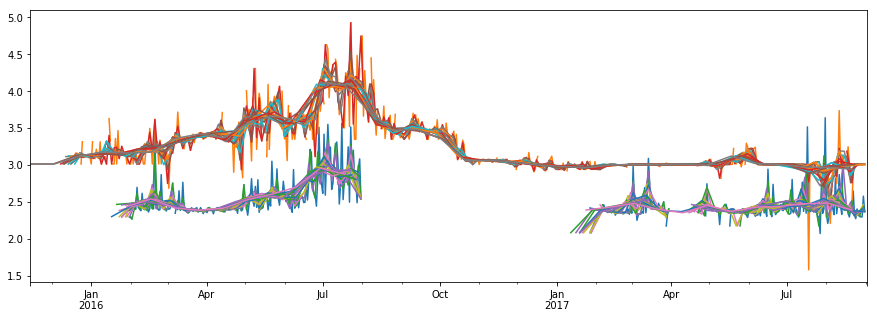

In [207]:
[t1.resample(x).mean().plot() and t2.resample(x).mean().plot() for x in cd]


In [183]:
ratio = t2.resample("1d").mean()/t1.resample("1d").mean()

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


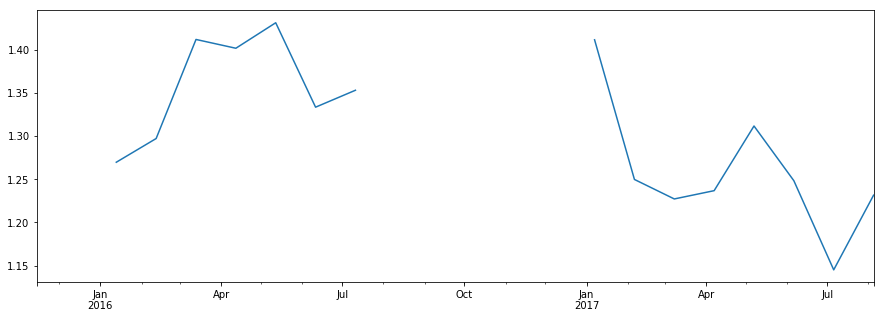

In [208]:
ratio.resample("30d").plot()

In [128]:
t2[t2.index.duplicated()]


Series([], dtype: float64)

In [129]:
s1[s1['date']=="2016-02-04 14:20:00"]


,Id,Customer Name,Status,Shipment Date,From City,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Creation Time,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Freight Amount,Product Name,Order Processing,Order Accepted,Order Blocked,Truck Arrival Source,date,ptr,date1,d
343317,16079,Hindustan Unilever Limited,Docs Received,04-Feb-2016 05:30 AM,Pondicherry,Chennai,193399.0,Puducherry,Ponneri,7500.0,16T/15T,04-Feb-2016 05:30 AM,UPY_Soaps & Detergent Factory,HUL Chennai ( Periyapalayam )_MMDH,FMCG,16.0,NaN,7500.0,FMC Durables,04-Feb-2016 05:30 AM,NaN,04-Feb-2016 02:20 PM,04-Feb-2016 03:55 PM,2016-02-04 14:20:00,2.423746,None,2016-02-04 14:20:02.000950
343318,16078,Hindustan Unilever Limited,Docs Received,04-Feb-2016 05:30 AM,Pondicherry,Chennai,193399.0,Puducherry,Ponneri,7710.0,16T/15T,04-Feb-2016 05:30 AM,UPY_Soaps & Detergent Factory,HUL Chennai ( Periyapalayam )_MMDH,FMCG,16.0,NaN,7500.0,FMC Durables,04-Feb-2016 05:30 AM,NaN,04-Feb-2016 02:20 PM,04-Feb-2016 03:55 PM,2016-02-04 14:20:00,2.423746,None,2016-02-04 14:20:12.000326


In [155]:
kpi.count()

Id                      359353
Customer Name           359353
From City               359353
To City                 359353
Distance                353871
From Sublocation        359353
To Sublocation          359353
Order Value             283832
Used truck Type         283610
Warehouse Start Loc     359353
Warehouse End Loc       359353
Sector Name             359353
Tonnage                 215205
Per Ton Rate              7864
Product Name            359353
Freight Amount          281265
Shipment Date           359353
Creation Time           359353
Order Processing        359353
Truck Arrival Source    285188
date                    104256
dtype: int64

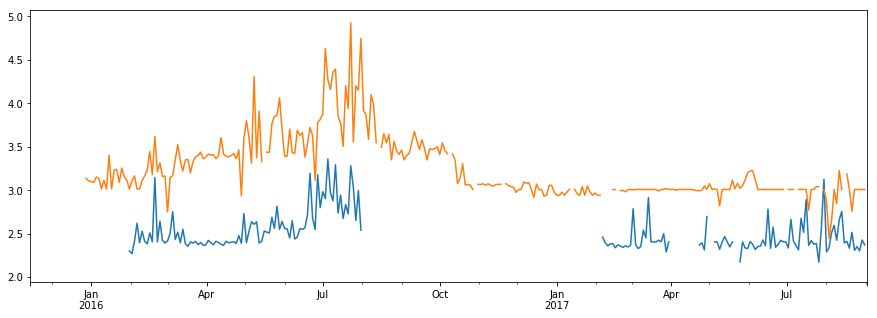

In [210]:
cd=["2d"]
[t1.resample(x).mean().plot() and t2.resample(x).mean().plot() for x in cd]


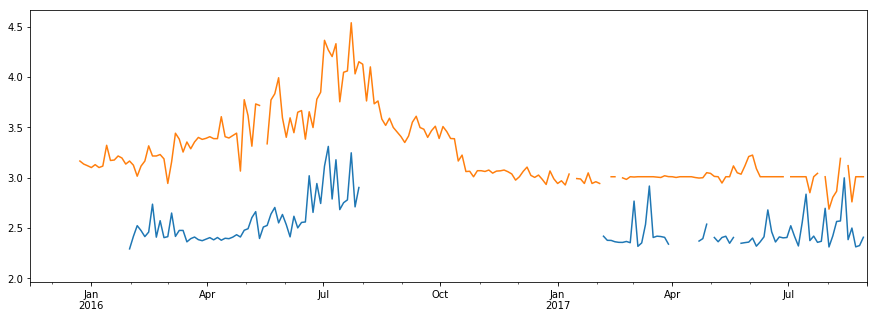

In [211]:
cd=["3d"]
[t1.resample(x).mean().plot() and t2.resample(x).mean().plot() for x in cd]


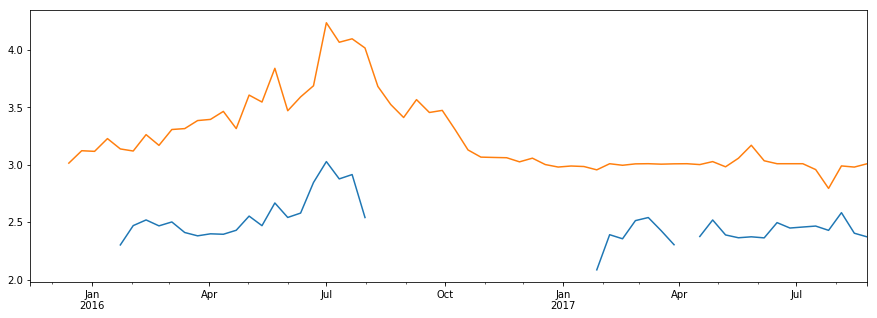

In [219]:
cd=["10d"]
[t1.resample(x).mean().plot() and t2.resample(x).mean().plot() for x in cd]
